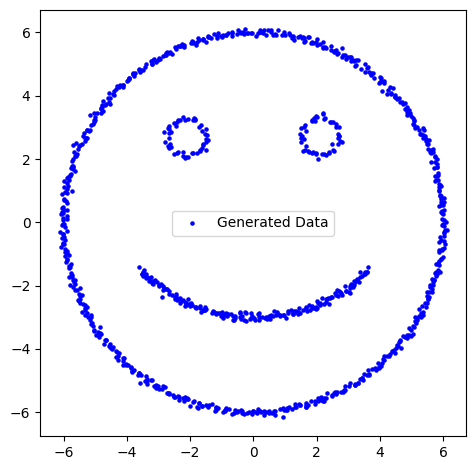

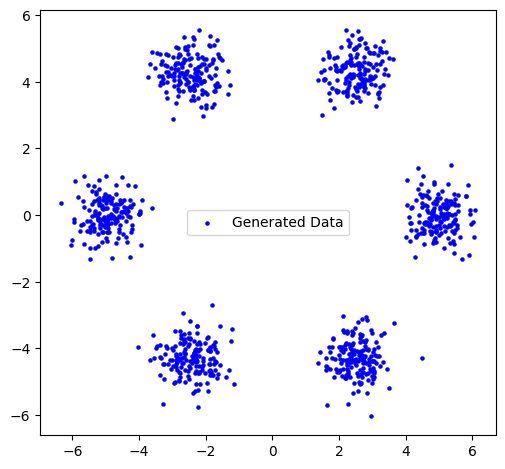

In [2]:
from data import generate_mixture_gaussians, generate_happy_face
from plotting_functions import plot_points
import jax

%load_ext autoreload
%autoreload 2

jax.config.update("jax_enable_x64", True)

x=generate_happy_face(1000)
y=generate_mixture_gaussians(1000)

plot_points(x)
plot_points(y)

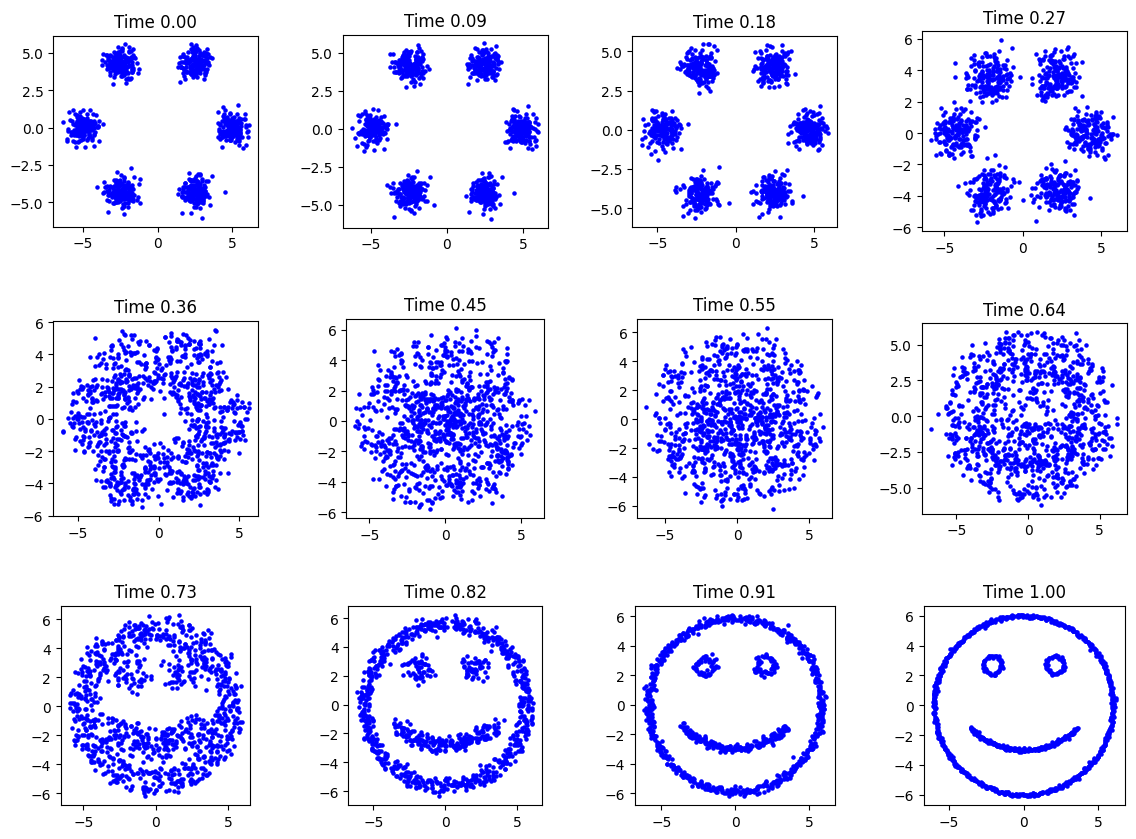

In [27]:
from sde import BridgeVPSDE
import jax.numpy as jnp
import jax.random as jr
from plotting_functions import plot_points_over_time


sde=BridgeVPSDE(.1, 1)

def generate_steps(x, y, times, key=jr.PRNGKey(0) ,T=1):
   
    # Initialize an array to store the generated points
    data = jnp.zeros((x.shape[0], 2, len(times)))
    
    # Loop over each time step
    for i, t in enumerate(times):

        key, subkey = jr.split(key)

        mean, std = sde.p(x, y, t, T)
        
        # Generate points using the normal distribution
        noise = jr.normal( subkey, x.shape)
        sample=mean + std * noise
        
        data = data.at[:, :, i].set(sample)  
        
    return data

# Example usage
times = jnp.linspace(0, 1, 12)  # 10 time steps from 0 to 1
data = generate_steps(x, y, times)
plot_points_over_time(data, times)


In [3]:
from Score_nets import Bridge_Diffusion_Net, UNet
import jax.random as jr

key=jr.PRNGKey(0)

UNet_Example=UNet(
        key=key,
        data_shape=(2,28,28),
        is_biggan=False,
        dim_mults=[1, 2, 4],
        hidden_size=64,
        heads=4,
        dim_head=32,
        dropout_rate=0.0,
        num_res_blocks=2,
        attn_resolutions=[16],
 
    )

model=Bridge_Diffusion_Net(key, 4,2)
print(model)

Bridge_Diffusion_Net(
  input_embedding=LearnedEmbedding(
    embedding=Linear(
      weight=f64[128,4],
      bias=f64[128],
      in_features=4,
      out_features=128,
      use_bias=True
    )
  ),
  time_embedding=SinusoidalEmbedding(scale=1.0, input_emb_size=128),
  joint_mlp=Sequential(
    layers=(
      Linear(
        weight=f64[128,256],
        bias=f64[128],
        in_features=256,
        out_features=128,
        use_bias=True
      ),
      Lambda(fn=PReLU(negative_slope=f64[])),
      Block(
        ff=Linear(
          weight=f64[128,128],
          bias=f64[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        act=PReLU(negative_slope=f64[])
      ),
      Block(
        ff=Linear(
          weight=f64[128,128],
          bias=f64[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        act=PReLU(negative_slope=f64[])
      ),
      Block(
        ff=Linear(
          we

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Step=0 Loss=2.317997282541285


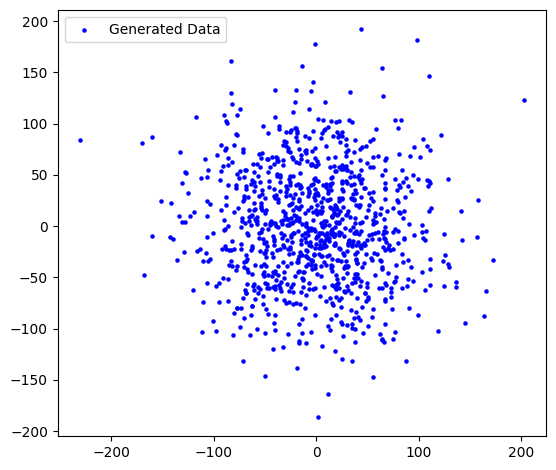

Step=1000 Loss=2.24734217589097
Step=2000 Loss=2.0987072485129614
Step=3000 Loss=2.059626005207318
Step=4000 Loss=2.0372380823197074
Step=5000 Loss=2.016476387185498
Step=6000 Loss=1.9959672452633634
Step=7000 Loss=1.977800064555407
Step=8000 Loss=1.9565068539761004
Step=9000 Loss=1.9360883663906627
Step=10000 Loss=1.9166996701447174


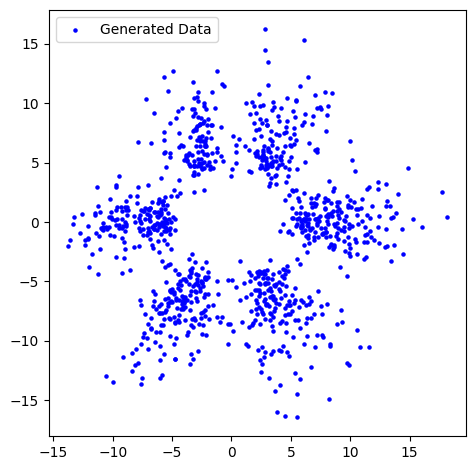

Step=11000 Loss=1.9033086160381079
Step=12000 Loss=1.885982543792845
Step=13000 Loss=1.8738699603728495
Step=14000 Loss=1.8627389676728605
Step=15000 Loss=1.8519782273140344
Step=16000 Loss=1.8423981867146113
Step=17000 Loss=1.8365093572419695
Step=18000 Loss=1.830027092735408
Step=19000 Loss=1.824337881422571
Step=20000 Loss=1.8192914465962198


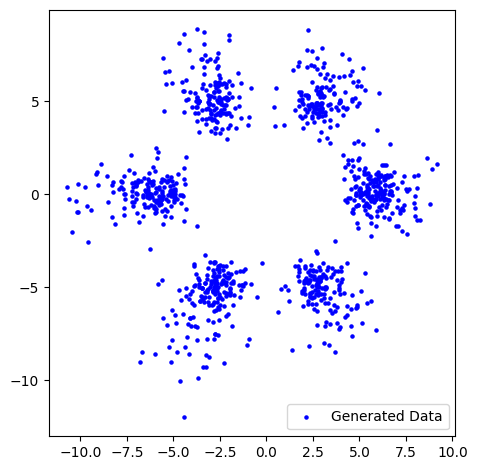

Step=21000 Loss=1.8147947532836899
Step=22000 Loss=1.8103655077248637
Step=23000 Loss=1.8086867843417254
Step=24000 Loss=1.804268758978707
Step=25000 Loss=1.801036200857377
Step=26000 Loss=1.7979145380925374
Step=27000 Loss=1.7954703516172807
Step=28000 Loss=1.79320695983597
Step=29000 Loss=1.7921081783185877
Step=30000 Loss=1.7886252645902263


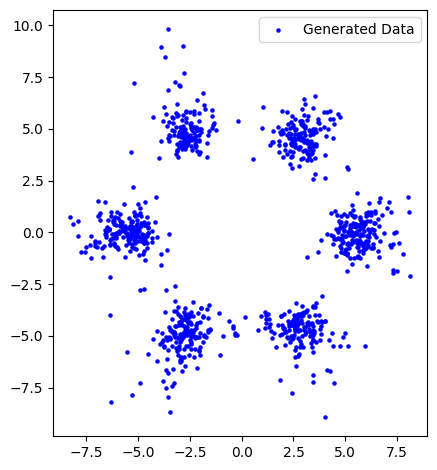

Step=31000 Loss=1.7872834992626065
Step=32000 Loss=1.7855243047503893
Step=33000 Loss=1.7846285800028294
Step=34000 Loss=1.782775621555992
Step=35000 Loss=1.7815142171833804
Step=36000 Loss=1.781086390594646
Step=37000 Loss=1.778197118200367
Step=38000 Loss=1.7771614380333731
Step=39000 Loss=1.776441620383436
Step=40000 Loss=1.7751413295679064


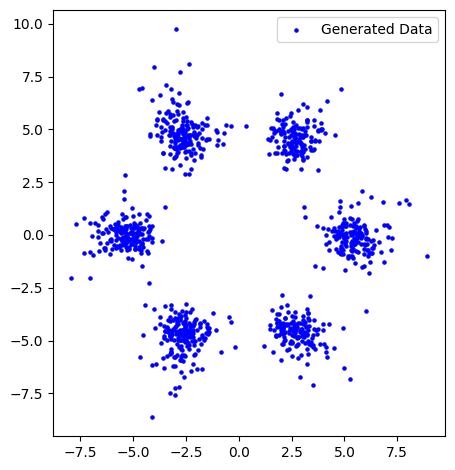

Step=41000 Loss=1.773824658240628
Step=42000 Loss=1.7728145245204943
Step=43000 Loss=1.7734325485041749
Step=44000 Loss=1.7703716391710198
Step=45000 Loss=1.7721111288836875
Step=46000 Loss=1.7706867959154131
Step=47000 Loss=1.7702909865745713
Step=48000 Loss=1.768975366173246
Step=49000 Loss=1.7667642933333698
Step=50000 Loss=1.767709462316996


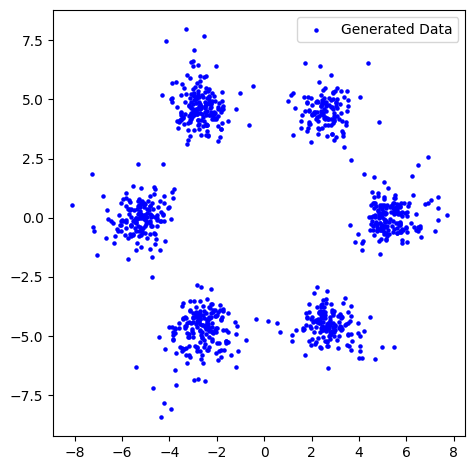

Step=51000 Loss=1.7661222885826782
Step=52000 Loss=1.766240637849046
Step=53000 Loss=1.7656033472115327
Step=54000 Loss=1.764252429678521
Step=55000 Loss=1.764114171535107
Step=56000 Loss=1.7638636951409625
Step=57000 Loss=1.7623249548638733
Step=58000 Loss=1.761361631852488
Step=59000 Loss=1.761819553050967
Step=60000 Loss=1.7617473845487293


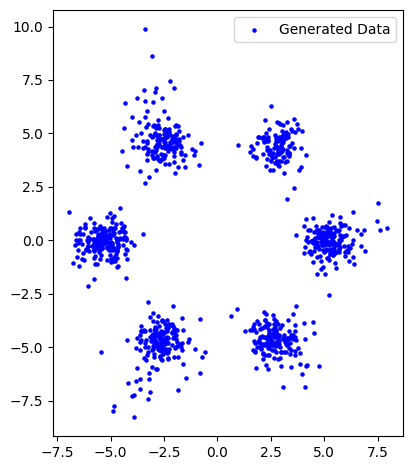

Step=61000 Loss=1.7600722696714528
Step=62000 Loss=1.7594420266535102
Step=63000 Loss=1.7601401100457004
Step=64000 Loss=1.7593109678661567
Step=65000 Loss=1.7582763840943658
Step=66000 Loss=1.7562986181846916
Step=67000 Loss=1.7571735037511833
Step=68000 Loss=1.7579504419789906
Step=69000 Loss=1.7559907315981444
Step=70000 Loss=1.7565799591872697


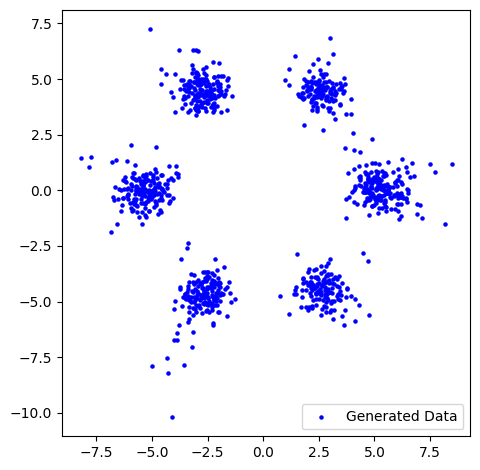

Step=71000 Loss=1.7561388596275347
Step=72000 Loss=1.7562053031768976
Step=73000 Loss=1.7552096920565665
Step=74000 Loss=1.7540999387536302
Step=75000 Loss=1.7544982894717653
Step=76000 Loss=1.7542357017677859
Step=77000 Loss=1.756027562023842
Step=78000 Loss=1.7525887657466694
Step=79000 Loss=1.7550414192569042
Step=80000 Loss=1.752560253534569


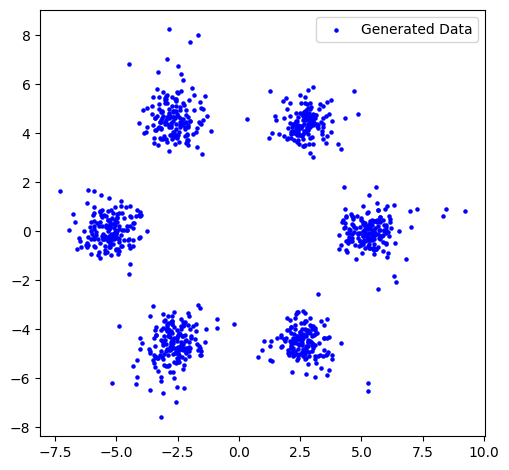

Step=81000 Loss=1.7517825233822828
Step=82000 Loss=1.7498562140238567
Step=83000 Loss=1.7529731728687048
Step=84000 Loss=1.7502818370179951
Step=85000 Loss=1.7512927461713033
Step=86000 Loss=1.7518490730439937
Step=87000 Loss=1.751434249836418
Step=88000 Loss=1.74968110056242
Step=89000 Loss=1.749765193678149
Step=90000 Loss=1.749112015603385


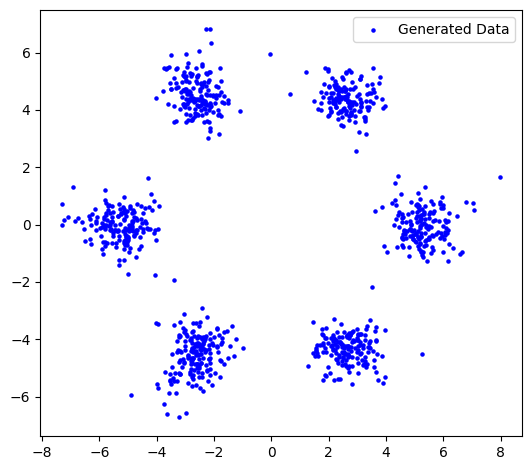

Step=91000 Loss=1.7494743017353664
Step=92000 Loss=1.749896287505008
Step=93000 Loss=1.7495140607570525
Step=94000 Loss=1.748260997982675
Step=95000 Loss=1.7484473618924214
Step=96000 Loss=1.7487120478561133
Step=97000 Loss=1.7481221932031574
Step=98000 Loss=1.747067849316222
Step=99000 Loss=1.7475448661714774
Step=99999 Loss=1.747569449369773


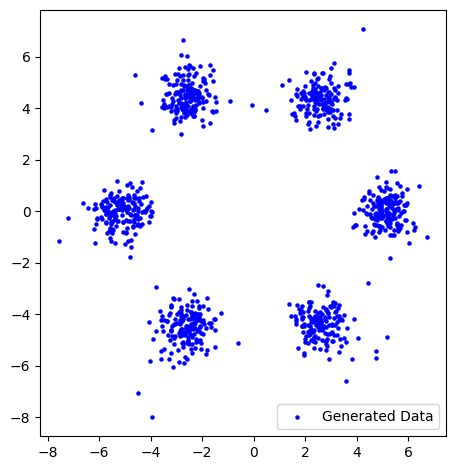

In [33]:

from train import main
import equinox as eqx

%load_ext autoreload
%autoreload 2

key = jr.PRNGKey(123)
x=generate_mixture_gaussians(100_000)
y=generate_happy_face(100_000)


model = eqx.tree_deserialise_leaves("checkpoints/Bridge/2d_bmin=.01_bmax=1.eqx", model)
main(model,
      x,
      sde,
      data_y=y,
      lr=1e-4,
      print_every=1000,
      filename="2d_bmin=.01_bmax=1"
      )